In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
os.chdir('..')

In [2]:
import numpy as np
from pathlib import Path
from ultralytics import YOLO
from utils.evaluation import (
    evaluate_yolo_model, 
    measure_yolo_speed,
    print_metrics,
    compare_models,
    visualize_failed_detections
)

In [3]:
# Константы
DATA_YAML = 'data/lpr_yolo/lpr_keypoints.yaml'
TEST_IMAGES = 'data/lpr_yolo/test/images'
TEST_LABELS = 'data/lpr_yolo/test/labels'
PROJECT_DIR = 'runs/lpr_keypoints'

### Baseline: YOLO11m-pose
 Начнем с обучения базовой модели среднего размера

In [ ]:
model = YOLO('data/pretrained_weights/yolo11m-pose.pt')

In [ ]:
results = model.train(
    data=DATA_YAML,
    epochs=15,
    imgsz=640,
    batch=16,
    project=PROJECT_DIR,
    name='yolo11m',
    device=0
)

Оценка baseline модели

In [10]:
metrics_m = evaluate_yolo_model(
    model_path=f'{PROJECT_DIR}/medium/weights/best.pt',
    test_images_dir=TEST_IMAGES,
    test_labels_dir=TEST_LABELS
)

print_metrics(metrics_m, "YOLO11m-pose")


  YOLO11m-pose
MAE:            1.54 px
RMSE:           2.23 px
Detection Rate: 99.80% (502/503)



Анализ неудачных детекций

Найдено 1 неудачных детекций


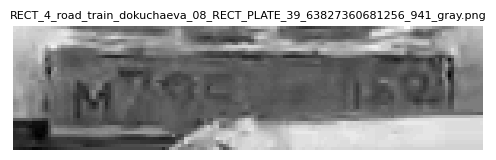

In [11]:
visualize_failed_detections(metrics_m['failed_detections'])

**Вывод:** Baseline модель показывает отличное качество (mAP50: 0.995), Detection Rate: 99.80%, но имеет большой размер(к тому же, модель может оказаться слишком глубокой для простой задачи). Попробуем уменьшить модель.

### YOLO11n-pose

In [ ]:
model_n = YOLO('data/pretrained_weights/yolo11n-pose.pt')
results_n = model_n.train(
    data=DATA_YAML,
    epochs=15,
    imgsz=640,
    batch=16,
    project=PROJECT_DIR,
    name='yolo11n',
    device=0,
    verbose=True
)

Ultralytics 8.3.221  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/lpr_yolo/lpr_keypoints.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-pose.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=nano, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspec

2025/10/28 23:42:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


MLflow: logging run_id(1f4b4f9a67e1495588fde0db54bfbc48) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to C:\Users\Nazgu\PycharmProjects\licenseplate-corner-localization\runs\lpr_keypoints\nano
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size
       1/15      11.1G     0.8076      1.734     0.5664     0.5875      1.151         27        640: 100% ━━━━━━━━━━━━ 503/503 4.3it/s 1:56<0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 48/48 4.5it/s 10.6s0.3s
                   all       1507       1507      0.998      0.999      0.995       0.83      0.998      0.999      0.995      0.906

      Epoch    GPU_mem   box_l

Оценка nano модели

In [4]:
metrics_n = evaluate_yolo_model(
    model_path=f'{PROJECT_DIR}/yolo11n/weights/best.pt',
    test_images_dir=TEST_IMAGES,
    test_labels_dir=TEST_LABELS
)

print_metrics(metrics_n, "YOLO11n-pose")


  YOLO11n-pose
MAE:            2.03 px
RMSE:           2.84 px
Detection Rate: 100.00% (503/503)



In [24]:
visualize_failed_detections(metrics_n['failed_detections'])

✓ Все детекции успешны!


**Вывод:** YOLO11n-pose показывает сопоставимое качество при значительно меньшем размере.

### Экспорт в ONNX

In [13]:
model_export = YOLO(f'{PROJECT_DIR}/yolo11n/weights/best.pt')
model_export.export(format='onnx', dynamic=True, simplify=True)

Ultralytics 8.3.221  Python-3.11.9 torch-2.5.1+cu121 CPU (11th Gen Intel Core i5-11400 @ 2.60GHz)
YOLO11n-pose summary (fused): 109 layers, 2,654,479 parameters, 0 gradients, 6.6 GFLOPs

PyTorch: starting from 'runs\lpr_keypoints\yolo11n\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 17, 8400) (5.4 MB)

ONNX: starting export with onnx 1.19.1 opset 19...
ONNX: slimming with onnxslim 0.1.72...
ONNX: export success  5.0s, saved as 'runs\lpr_keypoints\yolo11n\weights\best.onnx' (10.6 MB)

Export complete (5.4s)
Results saved to C:\Users\Nazgu\PycharmProjects\licenseplate-corner-localization\runs\lpr_keypoints\yolo11n\weights
Predict:         yolo predict task=pose model=runs\lpr_keypoints\yolo11n\weights\best.onnx imgsz=640  
Validate:        yolo val task=pose model=runs\lpr_keypoints\yolo11n\weights\best.onnx imgsz=640 data=data/lpr_yolo/lpr_keypoints.yaml  
Visualize:       https://netron.app


'runs\\lpr_keypoints\\yolo11n\\weights\\best.onnx'

### Сравнение производительности PyTorch vs ONNX

In [5]:
model_pt_path = f'{PROJECT_DIR}/yolo11n/weights/best.pt'
model_onnx_path = f'{PROJECT_DIR}/yolo11n/weights/best.onnx'

In [6]:
metrics_onnx = evaluate_yolo_model(
    model_path=model_onnx_path,
    test_images_dir=TEST_IMAGES,
    test_labels_dir=TEST_LABELS
)

Loading runs/lpr_keypoints/yolo11n/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.23.2 CUDAExecutionProvider


In [7]:
speed_pt = measure_yolo_speed(
    model_path=model_pt_path,
    test_images_dir=TEST_IMAGES
)
speed_onnx = measure_yolo_speed(
    model_path=model_onnx_path,
    test_images_dir=TEST_IMAGES
)

Loading runs/lpr_keypoints/yolo11n/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.23.2 CUDAExecutionProvider


In [8]:
compare_models({
    'YOLO11n PyTorch': {**metrics_n, **speed_pt},
    'YOLO11n ONNX': {**metrics_onnx, **speed_onnx}
})


Model                     MAE (px)     RMSE (px)    Speed (ms)     
--------------------------------------------------------------------------------
YOLO11n PyTorch           2.03         2.84         26.16          
YOLO11n ONNX              2.03         2.84         103.47         

